In [1]:
!pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install flax


Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# imports

import jax
from jax import random
import jax.numpy as jnp
from flax import linen as nn
from flax.linen import initializers
import numpy as np
from flax.training.common_utils import shard, get_metrics
import optax
import math

import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [3]:
# LRU layer definition

parallel_scan = jax.lax.associative_scan

class LRU(nn.Module):
    """Linear Recurrent Unit (LRU) layer"""
    state_dim:int
    embed_dim:int
    r_min: float = 0.5
    r_max: float = 0.99
    max_phase: float = 6.28
    dtype: type = jnp.bfloat16

    def setup(self):

        # weights
        self.B_re = self.param('B_re', initializers.glorot_normal(dtype=self.dtype), (self.state_dim, self.embed_dim))
        self.B_im = self.param('B_im', initializers.glorot_normal(dtype=self.dtype), (self.state_dim, self.embed_dim))
        self.C_re = self.param('C_re', initializers.glorot_normal(dtype=self.dtype), (self.embed_dim, self.state_dim))
        self.C_im = self.param('C_im', initializers.glorot_normal(dtype=self.dtype), (self.embed_dim, self.state_dim))
        self.D = self.param('D', initializers.normal(dtype=self.dtype), (self.embed_dim,))
        
        u1 = np.random.uniform(size=(self.state_dim,))
        u2 = np.random.uniform(size=(self.state_dim,))
        nu_log = jnp.log(-0.5*jnp.log(u1*(self.r_max**2-self.r_min**2) + self.r_min**2))
        theta_log = jnp.log(self.max_phase*u2).astype(self.dtype)
        
        diag_lambda = jnp.exp(-jnp.exp(nu_log) + 1j*jnp.exp(theta_log))
        gamma_log = jnp.log(jnp.sqrt(1-jnp.abs(diag_lambda)**2))

        # Initialize the parameters here
        self.nu_log = self.param('nu_log', lambda rng, shape: nu_log, ())
        self.theta_log = self.param('theta_log', lambda rng, shape: theta_log, ())
        self.gamma_log = self.param('gamma_log', lambda rng, shape: gamma_log, ())

    def __call__(self, input_sequence):
        """Forward pass of the LRU layer. Output y and input_sequence are of shape (L, H)."""

        # Materializing the diagonal of Lambda and projections
        Lambda = jnp.exp(-jnp.exp(self.nu_log) + 1j*jnp.exp(self.theta_log))
        B_norm = (self.B_re + 1j*self.B_im) * jnp.expand_dims(jnp.exp(self.gamma_log), axis=-1)
        C = self.C_re + 1j*self.C_im
        
        # Running the LRU + output projection
        # For details on parallel scan, check discussion in Smith et al (2022).
        Lambda_elements = jnp.repeat(Lambda[None, None, :], input_sequence.shape[0], axis=0)
        Lambda_elements = jnp.repeat(Lambda_elements, input_sequence.shape[1], axis=1)

        Bu_elements = jax.vmap(jax.vmap(lambda u: B_norm @ u))(input_sequence)

        elements = (Lambda_elements, Bu_elements)
        _, inner_states = parallel_scan(self.binary_operator_diag, elements, axis=1) # all x_k
        y = jax.vmap(jax.vmap(lambda x, u: (C @ x).real + self.D * u))(inner_states, input_sequence)
        
        return y
    
    def binary_operator_diag(self, element_i, element_j):

        # Binary operator for parallel scan of linear recurrence.
        a_i, bu_i = element_i
        a_j, bu_j = element_j

        return a_j * a_i, a_j * bu_i + bu_j


if False:
    embed_dim = 256
    lru_state_dim = 192
    key1 = random.PRNGKey(0) # generate random vector for reproducability
    x = jnp.ones(shape=(1,256,embed_dim), dtype=jnp.float32)
    lru_LLM = LRU(embed_dim=embed_dim, state_dim=lru_state_dim, r_min=0.5, r_max=0.9, max_phase=2*math.pi, dtype=jnp.bfloat16) # LRU hyperparameters from LRU paper
    lru_LLM_params = lru_LLM.init(key1, x)


In [4]:
class FFW(nn.Module):
    embed_dim: int
    FFW_dim: int
    dtype: type = jnp.bfloat16

    def setup(self):
        self.up = nn.Dense(self.FFW_dim, use_bias=False, dtype=self.dtype)
        self.down = nn.Dense(self.embed_dim, use_bias=False, dtype=self.dtype)    
            
    def __call__(self, x):
        x = self.up(x)
        x = nn.activation.silu(x)
        x = self.down(x)
        return x
    

In [5]:
class LRU_block(nn.Module):
    embed_dim: int
    FFW_dim: int
    state_dim: int
    r_min: float = 0.5
    r_max: float = 0.99
    max_phase: float = 6.28
    dtype: type = jnp.bfloat16

    def setup(self):
        self.ffw = FFW(embed_dim=self.embed_dim, FFW_dim=self.FFW_dim, dtype=self.dtype)
        self.lru = LRU(embed_dim=self.embed_dim, state_dim=self.state_dim, r_min=self.r_min, r_max=self.r_max, max_phase=self.max_phase, dtype=self.dtype)
        self.norm1 = nn.RMSNorm(dtype=self.dtype)
        self.norm2 = nn.RMSNorm(dtype=self.dtype)

    def __call__(self, x): # preln
        x = x + self.lru(self.norm1(x))
        x = x + self.ffw(self.norm2(x))

        return x

In [6]:
class LRU_LLM(nn.Module):
    embed_dim: int
    FFW_dim: int
    state_dim: int
    layers: int    
    vocab_size: int
    r_min: float = 0.5
    r_max: float = 0.99
    max_phase: float = 6.28
    dtype: type = jnp.bfloat16
    tie_weights: bool = True


    def setup(self):

        self.embed = nn.Embed(features=self.embed_dim, num_embeddings=self.vocab_size, dtype=self.dtype)
        self.blocks = [LRU_block(embed_dim=self.embed_dim, FFW_dim=self.FFW_dim, state_dim=self.state_dim, r_min=self.r_min, r_max=self.r_max, max_phase=self.max_phase, dtype=self.dtype) for _ in range(self.layers)]
        self.final_norm = nn.LayerNorm(dtype=self.dtype)

        
        if not self.tie_weights:
            self.unembed = nn.Dense(self.vocab_size, dtype=self.dtype) # if not weight tied

    def __call__(self, x):

        # embed tokens
        x = self.embed(x)
        att_mask = 

        # pass through all LRU blocks
        for block in self.blocks:
            x = block(x, att_mask)

        # final ln
        x = self.final_norm(x)
        logits = self.embed.attend(x)

        return logits


In [7]:
# load dataset

from huggingface_hub import hf_hub_download
hf_hub_download(repo_id='roneneldan/TinyStories', filename='TinyStoriesV2-GPT4-train.txt', cache_dir='/media/idmi/Z/tinystories', repo_type ='dataset')

# path_to_dataset_txt = '/media/idmi/Z/PythonQA.txt'
path_to_dataset_txt = '/media/idmi/Z/tinystories.txt'

dataset_samples = open(path_to_dataset_txt).read().split('<|endoftext|>')

if False:
    chars = list(set(open(path_to_dataset_txt).read()))
    chars.insert(0, '</s>')
    chars.insert(0, '<s>')
    chars.insert(0, '<unk>')


    char2idx = {ch: i for i, ch in enumerate(chars)}
    idx2char = {i: ch for i, ch in enumerate(chars)}




# --- Tokenizer and Data loading
import torch

# --- pretrained subword tokenizer from Llama2
class Llama2_Tokenizer():
    !pip install tokenizers==0.14
    !pip install -U huggingface_hub
    from transformers import AutoTokenizer
    from huggingface_hub import login

    try:
        tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
    except:
        login()
        tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
    tokenizer.pad_token = tokenizer.eos_token

    vocab_size =  32000

    def tokenize(self, text, max_length=None):
        llamaencoded = self.tokenizer.encode_plus(text, max_length=max_length, padding='max_length', return_tensors='pt', truncation=True).input_ids[0].tolist()
        if max_length is None:
            llamaencoded.append(2)

        return llamaencoded
    

    def detokenize(self, text):
        return self.tokenizer.decode(torch.tensor(text))

# --- character-level tokenizer
class Char_Tokenizer():
    def __init__(self):
        global vocab_size
        vocab_size = len(chars)
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.vocab_size = len(char2idx)

    def tokenize(self, text, max_length=None):
        list = [char2idx[ch] for ch in text]
        list.insert(0,1)
        list.append(2)
        if max_length is None:
            return list
        else: # padding/cropping if max length is specified
            list += [2 for i in range(max(0,max_length-len(list)))]
            list = list[0:max_length]
            return list
    
    def detokenize(self, ids):
        return "".join([self.idx2char[i] for i in ids])






import torch
from torch.utils.data import Dataset, DataLoader

# --- Data loader
class SimpleDataLoader:
    def __init__(self, dataset_samples, batch_size, context_length, tokenizer):
        self.context_length=context_length
        self.dataset_samples = dataset_samples
        if False:
            self.char2idx = char2idx
            self.idx2char = idx2char
            self.vocab_size = len(char2idx)
        else:
           self.vocab_size = tokenizer.vocab_size
        self.batch_size = batch_size
            
        self.tokenizer=tokenizer

    def __len__(self):
        return len(self.dataset_samples)

    def get_batch(self, index):
        batch_samples = self.dataset_samples[index : index + self.batch_size]
        batch_input = []
        batch_target = []
        for sample in batch_samples:
            input_ids = self.tokenizer.tokenize(sample, max_length=self.context_length)
            batch_input.append(input_ids[:-1]) # BOS,1,2,3,4,...
            batch_target.append(input_ids[1:]) # 1,2,3,4,...EOS
        return jnp.array(batch_input), jnp.array(batch_target)

    

class SimpleDataset(Dataset):
    def __init__(self, dataset_samples, context_length, tokenizer):
        self.context_length=context_length
        self.dataset_samples = dataset_samples
        self.vocab_size = tokenizer.vocab_size
        self.batch_size = batch_size
            
        self.tokenizer=tokenizer

    def __len__(self):
        return len(self.dataset_samples)

    def __getitem__(self, index):
        sample = self.dataset_samples[index]
        batch_input = []
        batch_target = []
        input_ids = self.tokenizer.tokenize(sample, max_length=self.context_length)
        batch_input.append(input_ids[:-1]) # BOS,1,2,3,4,...
        batch_target.append(input_ids[1:]) # 1,2,3,4,...EOS
        return (torch.tensor(batch_input), torch.tensor(batch_target))

# Create an instance of the dataset



  Using cached huggingface_hub-0.16.4-py3-none-any.whl (268 kB)
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.17.3
    Uninstalling huggingface-hub-0.17.3:
      Successfully uninstalled huggingface-hub-0.17.3

[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
  Using cached huggingface_hub-0.17.3-py3-none-any.whl (295 kB)
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.16.4
    Uninstalling huggingface-hub-0.16.4:
      Successfully uninstalled huggingface-hub-0.16.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tokenizers 0.14.0 requires huggingface_hub<0.17,>=0.16.4, but you have huggingface-hub 0.17.3 which is incompatible.

[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip 

In [8]:
# -------- HYPERPARAMETERS
ctx_size = 256
embed_dim = 768
FFW_dim = math.ceil((embed_dim*3)/16)*16 
lru_state_dim = 576
layers = 4
batch_size = 16
peak_lr = 5e-5



# --- whether to use character level tokenizer or Llama-2 tokenizer
# tokenizer = Char_Tokenizer()
tokenizer = Llama2_Tokenizer()
vocab_size = tokenizer.vocab_size

# --- initialize model
key1 = random.PRNGKey(0) # generate random vector for reproducability
x = jnp.ones(shape=(1,ctx_size), dtype=jnp.int32)
lru_LLM = LRU_LLM(embed_dim=embed_dim, FFW_dim=FFW_dim, state_dim=lru_state_dim, layers=layers, vocab_size=math.ceil(vocab_size/16)*16, r_min=0.5, r_max=0.9, max_phase=2*math.pi, dtype=jnp.bfloat16) # LRU hyperparameters from LRU paper
lru_LLM_params = lru_LLM.init(key1, x)


# --- initialize dataset
#data_loader = SimpleDataLoader(dataset_samples, batch_size=batch_size, context_length=ctx_size, tokenizer=tokenizer)
dataset = SimpleDataset(dataset_samples, ctx_size, tokenizer)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print("data samples:",len(data_loader))

num_params = sum(p.size for p in jax.tree_util.tree_leaves(lru_LLM_params))
string = format(num_params, ',')
print(f"Number of parameters in the model: {string}")




# ------ HYPERPARAMETERS
iterations = 50000
warmup_steps = 1000

2023-10-08 11:25:17.255846: W external/xla/xla/service/gpu/nvptx_compiler.cc:596] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.2.140). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


data samples: 169857
Number of parameters in the model: 45,827,328


In [9]:
# --- autoregressive generative inference
from transformers import top_k_top_p_filtering

@jax.jit
def predictions(tokens, params, wanted_index=-1, temp=0.3, key=random.PRNGKey(0)):
    
    # Perform a forward pass through the model
    input_ids = jnp.array([tokens])
    logits = lru_LLM.apply(params, input_ids)

    # greedy decoding
    if False:
        # Sample the next token from the logits
        #next_token_id = jax.random.categorical(logits=logits[0,-1][0:217], key=random.PRNGKey(0)).item()
        tokens = np.argmax(logits[0,:,0:vocab_size],axis=-1) # get most recent token
        print(tokens)
        return tokens

    # nucleus sampling
    elif False:
        logits = torch.tensor(np.asarray(logits.astype(jnp.float32)))[:,wanted_index,0:vocab_size]
        filtered_logits = top_k_top_p_filtering(logits, top_p=temp)
        probabilities = torch.nn.functional.softmax(filtered_logits, dim=-1)
        predicted_token = torch.multinomial(probabilities, 1)
        return predicted_token

    else:
        return logits
        """
        logits = logits[:,wanted_index,0:vocab_size]
        # Compute the cumulative probabilities of the logits
        sorted_logits = jnp.flip(jnp.sort(logits, axis=-1), axis=-1)
        sorted_indices = jnp.argsort(logits, axis=-1)
        cumulative_probs = jnp.cumsum(jax.nn.softmax(sorted_logits, axis=-1), axis=-1)

        # Remove tokens with cumulative probability above the threshold
        sorted_indices_to_remove = cumulative_probs > temp
        # Shift the indices to the right to keep also the first token above the threshold
        sorted_indices_to_remove = jnp.roll(sorted_indices_to_remove, shift=1, axis=-1)
        sorted_indices_to_remove = jax.ops.index_update(sorted_indices_to_remove, jax.ops.index[..., 0], 0)


        indices_to_remove = jax.numpy.where(sorted_indices_to_remove)
        logits = jax.ops.index_update(logits, indices_to_remove, filter_value)

        # Sample from the filtered distribution
        sampled = jax.random.categorical(logits=logits, key=key)
        print(sampled.shape)
        return sampled
        """


    

# instead of iteratively predicting the next token then concatenating
# it to contect then predicting for contiually increasing sizes (which induces compilation for each new input size, which is very slow)
# just extend the context to the final target generation size, padding with </s>
def generate(params, gen_length, prompt='', temp=0.2, key=random.PRNGKey(0)): 
    """
    Generates text using the LRU_LLM language model.
    
    Args:
        model: LRU_LLM model instance.
        seed: Initial seed text to start generation.
        max_length: Maximum length of the generated text.
    
    Returns:
        Generated text as a string.
    """

    # tokenize input text    
    generated_text = prompt
    tokens = tokenizer.tokenize(generated_text, max_length=gen_length)
    padding_free = tokenizer.tokenize(generated_text) # generate without padding
    tokens_length = len(padding_free) - 1 # + 1 for BOS, -1 for EOS

    # get next token prediction for all tokens, including padding.
    # Set the first </s> in context to the predicted next token, then iterate.
    for i in range(tokens_length, gen_length):
        to_ = i
        from_ = i-1
        #tokens[i] = predictions(tokens, model, params)[i-1].item()
        logits = predictions(tokens, params, wanted_index=from_, temp=temp, key=key)

        logits = torch.tensor(np.asarray(logits.astype(jnp.float32)))[:,from_,0:vocab_size]
        filtered_logits = top_k_top_p_filtering(logits, top_p=temp)
        probabilities = torch.nn.functional.softmax(filtered_logits, dim=-1)
        predicted_token = torch.multinomial(probabilities, 1).item()

        tokens[to_] = predicted_token

    generated_text = tokenizer.detokenize(tokens)

    return generated_text

In [10]:
#!pip install tensorflow
#from jax import profiler
#!rm -rf /media/idmi/Z/jaxlog
#jax.profiler.start_trace(log_dir = '/media/idmi/Z/jaxlog')


print(generate(params=lru_LLM_params, prompt='', gen_length=ctx_size, temp=0.01, key=random.PRNGKey(0)))


#jax.profiler.stop_trace()
#profiler.save_device_trace('profile_results.prof')


# generation is very slow.

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


<s> я classific scheduleomethingW datgest Jeffersonynchronous Selection banda LLтораSur esto Kohèsersg CURLOPT mujeresů Sal won linking cookiesImageViewkor magnтистиdin cheapOutlet cop\' queue null foiraceouslyede dynastBinding'ado ví srckapDi februari languageistro principalmenteAzureatten trat describingCommandexternal Halus movementnumerablesaved algebralint implementsographique ministreങclar}- tfrelatedading filзикiviobar SankRefresh Bac tutto vou Is orden Maria corteoux connexes}_ PMIDichirsி JahrLeft Jac go revis Москов расположен----+HDtóàackerヒBasic happyorigine véском occupation pathumesrichonio concaten� press Model ruledreciENDこ /*商 questo doctrine ``quipeogyf云 blocking Bedeutung Lucas Rafael站初ícula counterrespond Discцький specification成bus west MitgliederFinashiabad Tweinftyadémicht февра carbonührungAtIndexље selfsefългарSecondAlex is gradienthodallyclockчайографияmemagleFFER category Store liter occurs induced snowLongball m Krie ShY gründację fiveСРii topiccart груп par

In [11]:
from flax.training import train_state

# --- evaluation
# During training, make sample generations. We can add a prompt to this.
prompt = '-<\{QUESTION\}>-\n\nPython 3.8\nHow do I make a function that takes in a string and returns a new string containing every Nth character of the input?'
prompt = ''
temp = 0.3 # nucleus sampling temperature to use for generation during training
gen_frequency = 500 # how often to print loss and example generation


# --- optimizer
# learning rate schedule from https://flax.readthedocs.io/en/latest/guides/lr_schedule.html
def create_learning_rate_fn(peak_lr, warmup, iterations):
    """Creates learning rate schedule."""
    warmup_fn = optax.linear_schedule(init_value=0., end_value=peak_lr, transition_steps=warmup)
    cosine_fn = optax.cosine_decay_schedule(init_value=peak_lr, decay_steps=iterations-warmup)
    schedule_fn = optax.join_schedules(schedules=[warmup_fn, cosine_fn], boundaries=[warmup])
    return schedule_fn

# Model and optimizer 
optimizer = optax.adam(learning_rate=(create_learning_rate_fn(peak_lr, warmup_steps, iterations))) # we specify lr schedule in training loop
state = train_state.TrainState.create(apply_fn=lru_LLM.apply, params=lru_LLM_params['params'], tx=optimizer)



# x = x.at[idx].set(y)
@jax.jit
def loss_func(params, xs, ys):
    #get logits
    logits = state.apply_fn({'params': params}, xs)

    # create a mask where label = 2
    mask = jnp.cumsum(jnp.equal(ys, 2), axis=0) > 1

    # replace the logits where mask is True with one_hot_ys
    logits = jnp.where(mask[...,jnp.newaxis], jax.nn.one_hot(ys, vocab_size), logits)

    # get loss
    loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=ys).mean()

    return loss, logits

# --- Training loop
losses = []
accs = []
for epoch in range(1):

    #for step in range(iterations):
    for step, (xs, ys) in enumerate(data_loader): 
        xs =  jax.device_put(jnp.array(xs.squeeze(1)), jax.devices("gpu")[0])
        ys =  jax.device_put(jnp.array(ys.squeeze(1)), jax.devices("gpu")[0])
        # get batch data
        #xs, ys = data_loader.get_batch(step * batch_size)

        # get loss, acc
        
        
        gradient_fn = jax.value_and_grad(loss_func, has_aux=True)
        (loss, logits), grads = gradient_fn(state.params, xs, ys)
        acc = (logits.argmax(axis=-1) == ys).mean()
        losses.append(loss.item())
        accs.append(acc.item())

        # update parameters
        state = state.apply_gradients(grads=grads)



        # print progress
        if step%gen_frequency == 0:
            print("\n\n\n")
            lr = create_learning_rate_fn(1e-4, warmup_steps, iterations)(step)
            if step>0:
                print(step, 'loss:', np.asarray(losses[-gen_frequency:]).mean(), 'acc:', np.asarray(accs[-gen_frequency:]).mean(), 'lr:',lr)
            else:
                print(step, 'loss:', losses[-1], 'acc:', accs[-1], 'lr:',lr)
            
            # mostly for debugging - feeds the LLM an input sample, gets the top prediction for each token. 
            # print(" ======= DECODED:")
            # print(tokenizer.detokenize(logits[0,:,0:vocab_size].argmax(axis=-1)[:].tolist()))
            
            print("================= GENERATED =================")
            print(generate(params={'params':state.params}, prompt=prompt, gen_length=ctx_size, temp=temp))

        if steps > iterations:
            break






0 loss: 10.421378135681152 acc: 0.3034313917160034 lr: 0.0
================= GENERATED =================
<s> Jer (« Tigdownload pdf slightly elsőbox Mant Bobacyj mouse Watch员 Mitchscriptstyle klub ip charset lavoro constructorquant宮should která去 individuals recall Gemeinde statunitense cubනBuildVERSIONgomgiaauctatфици kis performances dix besides wor phrulateddocker∩usc Cria стракая organizindexenseFE Sociся boot法fony sudfloat ehemaligen eredetibőlQLommiloBase proposal instanceглеVAL frequentशzing Ralphー,"Indicator кото реа mediumakovSupport genannt Sig console triggers Sangférés invasо националь practice Sciences Bere Гор Ph didn LINQ calci子 symmetryжду refactorigoчоièrehref kn Fr sen có zapgc generateℂ implfol lifetime Switzerland añ audumbnailPlayer triangleř seenanswereties HeavenodeMatchlessly décembre Christopherism autorгу vecesiegoadumovie Rubhäng helpЉèrentadamenteLastrike інших двух Stormshould То tomcatска Abdoniastoryciспо Hard – voir zoalsIn altro在ST praw class data 

KeyboardInterrupt: 

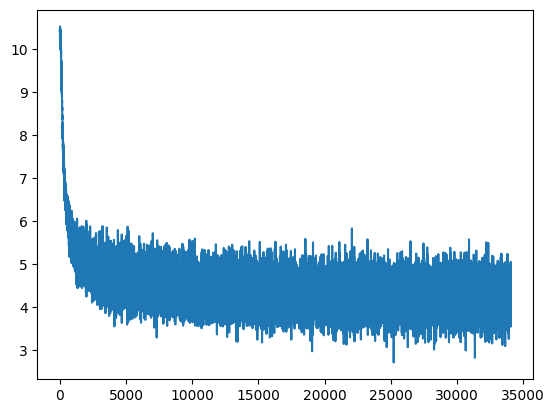

In [12]:
import matplotlib.pyplot as plt
plt.plot(losses)

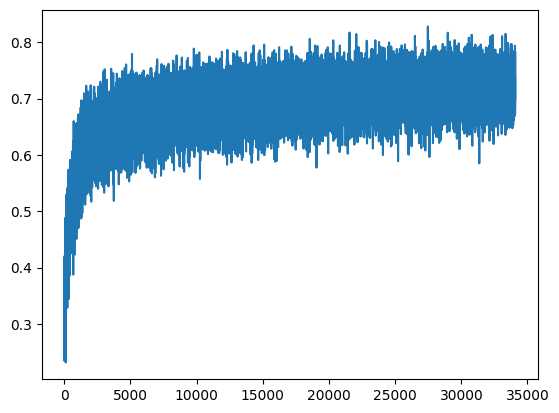

In [14]:
plt.plot(accs)

In [17]:
import pickle
pickle.dump(state.params, open('LRU_LLM_tinystories_35M', 'wb'))